In [2]:
# import package
# installed via pip
from emtracks.particle import * # main solver object
from emtracks.conversions import one_gev_c2_to_kg # conversion for q factor (transverse momentum estimate)
from emtracks.tools import *#InitConds # initial conditions namedtuple
from emtracks.mapinterp import get_df_interp_func  # factory function for creating Mu2e DS interpolation function
from emtracks.Bdist import get_B_df_distorted
from emtracks.interpolations import *
import matplotlib.animation as animation
import numpy as np
from scipy.constants import c, elementary_charge
import pandas as pd
import pickle as pkl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [24,16] # bigger figures
from matplotlib import style
style.use('fivethirtyeight')
import os

from joblib import Parallel, delayed
import multiprocessing
from tqdm.notebook import tqdm


rad13plotdir = '/home/shared_data/mao10,mao13_analysis/plots/mao13(0.90,1.10TS)rad/'
reg13plotdir = '/home/shared_data/mao10,mao13_analysis/plots/mao13(0.90,1.10TS)/'
mao13datadir = '/home/shared_data/mao10,mao13_analysis/data/mao13(0.90,1.10TS)/'

ERROR! Please set $EMTRACKS_DDIR and $EMTRACKS_PDIR. Setting defaults (current directory)


In [3]:
files = sorted(os.listdir(mao13datadir)) #all your files

In [3]:
files[0]

'0.90_0.000_0.000_0.054_.pkl'

In [4]:
files[0].split('_')

['0.90', '0.000', '0.000', '0.054', '.pkl']

In [5]:
field = files[0].split('_')[0]
theta = files[0].split('_')[1]
phi = files[0].split('_')[2]
def get_uniform_phi(N):
    phis = np.linspace(0, 2*math.pi, N)
    return phis

In [6]:
phis = get_uniform_phi(50)
data = [1.53873926, 1.60285339, 1.66696753, 1.73108167, 1.7951958 , 1.85930994, 1.92342407, 1.98753821, 2.05165235, 2.11576648, 2.17988062]

In [7]:
def getDSfield(file):
    return file.split('_')[1].split('x')[0]
def getPSfield(file):
    return file.split('_')[2].split('x')[0]

def getfiles(files, field, thetas, phis):
    fieldrounded = round(field, 3)
    thetasrounded = [round(num, 3) for num in thetas]
    phisrounded = [round(num, 3) for num in phis]
    
    filedata = []
    for file in files:
        if np.isclose(float(file.split('_')[0]), field, 1e-3):
            if float(getDSfield(file)) in thetasrounded:
                if float(getPSfield(file)) in phisrounded:
                    filedata.append(file)
    
    return filedata

filenames = getfiles(files, 0.90, data, phis)
filenames2 = getfiles(files, 1.00, data, phis)

#filenames - all files with data, phis and field = 0.90, filenames2 '' 

In [8]:
def readpklold(zstart, zend, numpoints, files):
    zsteps = np.linspace(zstart, zend, numpoints)
    data = []
    deleted = []

    for file in files:
        x = file.split('_')
        field = x[0]
        e_solvernom = trajectory_solver.from_pickle(mao13datadir+file)
        phi = e_solvernom.init_conds.phi0
        theta = e_solvernom.init_conds.theta0
        for z in zsteps:
            if z > e_solvernom.dataframe.z.max() or z < e_solvernom.dataframe.z.min():
                data.append(8*[np.nan])
                deleted.append([e_solvernom.init_conds.theta0, e_solvernom.init_conds.phi0])
            else:
                info = interp_cole(e_solvernom.dataframe, z)
                x = info[1]
                y = info[2]
                r = tuple([(x**2 + y**2)**(1/2)])
                r2 = tuple([((x-0.054094482)**(2) + (y-0.03873037)**(2))**(1/2)])
                tuple1 = (z, field, theta, phi)
                
                nan = tuple([np.nan])

                data.append(tuple1 + info + r + r2)
                
    return data, deleted

In [10]:
x, deleted = readpklold(6, 13, 8, filenames) #dis 

In [11]:
len(deleted)

568

In [12]:
y, deleted2 = readpklold(6, 13, 8, filenames2) #norm

In [13]:
len(deleted2)

256

In [14]:
dfdis = pd.DataFrame(deleted, columns = ['theta', 'phi']) #dis
dfnom = pd.DataFrame(deleted2, columns = ['theta', 'phi']) #nom

In [53]:
dfdis

,theta,phi
0,2.115766,1.795196
1,2.115766,1.795196
2,2.115766,1.795196
3,2.115766,1.795196
4,2.115766,1.795196
...,...,...
563,2.179881,6.283185
564,2.179881,6.283185
565,2.179881,6.283185
566,2.179881,6.283185


In [15]:
dfdis['theta'].unique()

array([2.11576648, 2.17988062])

In [16]:
dfnom['theta'].unique()

array([2.17988062])

In [17]:
#above two lines say in dis theta with 2.11, 2.17 have deleted values due to bounds
#however, nom theta with 2.17 only have deleted values due to bounds

In [18]:
missingphis = dfdis[np.isclose(dfdis['theta'], 2.11576648, 1e-2)]['phi'].unique()
len(missingphis)

21

In [19]:
missingphis2 = []
missingphis3 = dfdis[np.isclose(dfdis['theta'], 2.17988062, 1e-2)]['phi'].unique()
missingphis4 = dfnom[np.isclose(dfnom['theta'], 2.17988062, 1e-2)]['phi'].unique()
for phi in missingphis3:
    if phi in missingphis4:
        x = 1
    else:
        missingphis2.append(phi)
#get all the missingphis in the distorted field that are not in the nominal field
len(missingphis2)

18

In [20]:
thetadata = [2.11576648]
def getfiles(files, field, thetas, phis):
    fieldrounded = round(field, 3)
    thetasrounded = [round(num, 3) for num in thetas]
    phisrounded = [round(num, 3) for num in phis]
    
    filedata = []
    for file in files:
        if np.isclose(float(file.split('_')[0]), field, 1e-3):
            if float(getDSfield(file)) in thetasrounded:
                if float(getPSfield(file)) in phisrounded:
                    filedata.append(file)
    
    return filedata

filedata = getfiles(files, 0.90, thetadata, missingphis)
filedata2 = getfiles(files, 1.00, thetadata, missingphis)

In [27]:
#all the file names with the missingphis and theta = 2.115766

In [28]:
thetadata2 = [2.17988062]
filedata3 = getfiles(files, 0.90, thetadata2, missingphis2)
filedata4 = getfiles(files, 1.00, thetadata2, missingphis2)

In [29]:
#all the file names with missing phis and theta = 2.179

In [30]:
maxzdis = []
for file in filedata:
    e_solverdis = trajectory_solver.from_pickle(mao13datadir+file)
    maxzdis.append([max(e_solverdis.dataframe.z.values), e_solverdis.init_conds.theta0, e_solverdis.init_conds.phi0])

maxz = []
for file in filedata2:
    e_solvernom = trajectory_solver.from_pickle(mao13datadir+file)
    maxz.append([max(e_solvernom.dataframe.z.values), e_solvernom.init_conds.theta0, e_solvernom.init_conds.phi0])
    


In [33]:
maxz

[[14.13929989216126, 2.1157664809890444, 1.7951958020513104],
 [14.138900378961708, 2.1157664809890444, 1.9234240736264039],
 [14.135295240466029, 2.1157664809890444, 2.0516523452014974],
 [14.138114937361356, 2.1157664809890444, 2.179880616776591],
 [14.143896606643557, 2.1157664809890444, 2.3081088883516845],
 [14.13960754139078, 2.1157664809890444, 2.436337159926778],
 [14.142575609207263, 2.1157664809890444, 2.5645654315018716],
 [14.13696144480473, 2.1157664809890444, 2.6927937030769655],
 [14.13727549538945, 2.1157664809890444, 2.821021974652059],
 [14.138159451368317, 2.1157664809890444, 2.9492502462271526],
 [14.136593085043561, 2.1157664809890444, 3.077478517802246],
 [14.140519648744533, 2.1157664809890444, 3.2057067893773397],
 [14.13625665448291, 2.1157664809890444, 3.333935060952433],
 [14.140876869935013, 2.1157664809890444, 3.8468481472528078],
 [14.140806204022565, 2.1157664809890444, 3.9750764188279013],
 [14.142776572495016, 2.1157664809890444, 4.103304690402995],
 [1

In [43]:
maxzdis

[[5.988900879, 2.1157664809890444, 1.7951958020513104],
 [5.988900879, 2.1157664809890444, 1.9234240736264039],
 [5.988900879, 2.1157664809890444, 2.0516523452014974],
 [5.988900879, 2.1157664809890444, 2.179880616776591],
 [5.988900879, 2.1157664809890444, 2.3081088883516845],
 [5.988900879, 2.1157664809890444, 2.436337159926778],
 [5.988900879, 2.1157664809890444, 2.5645654315018716],
 [5.988900879, 2.1157664809890444, 2.6927937030769655],
 [5.988900879, 2.1157664809890444, 2.821021974652059],
 [5.988900879, 2.1157664809890444, 2.9492502462271526],
 [5.988900879, 2.1157664809890444, 3.077478517802246],
 [5.988900879, 2.1157664809890444, 3.2057067893773397],
 [5.988900879, 2.1157664809890444, 3.333935060952433],
 [5.988900879, 2.1157664809890444, 3.8468481472528078],
 [5.988900879, 2.1157664809890444, 3.9750764188279013],
 [5.988900879, 2.1157664809890444, 4.103304690402995],
 [5.988900879, 2.1157664809890444, 4.231532961978089],
 [5.988900879, 2.1157664809890444, 4.487989505128276],


In [36]:
maxzdis2 = []
for file in filedata3:
    e_solverdis = trajectory_solver.from_pickle(mao13datadir+file)
    maxzdis2.append([max(e_solverdis.dataframe.z.values), e_solverdis.init_conds.theta0, e_solverdis.init_conds.phi0])

maxz2 = []
for file in filedata4:
    e_solvernom = trajectory_solver.from_pickle(mao13datadir+file)
    maxz2.append([max(e_solvernom.dataframe.z.values), e_solvernom.init_conds.theta0, e_solvernom.init_conds.phi0])
    


In [42]:
maxz2

[[14.135853621229, 2.179880616776591, 0.0],
 [14.138837256078606, 2.179880616776591, 0.1282282715750936],
 [14.137911571656474, 2.179880616776591, 4.359761233553182],
 [14.140590288556247, 2.179880616776591, 4.487989505128276],
 [14.139415940047915, 2.179880616776591, 4.616217776703369],
 [14.138348020285743, 2.179880616776591, 4.744446048278463],
 [14.142113194430827, 2.179880616776591, 4.872674319853556],
 [14.137219109490099, 2.179880616776591, 5.00090259142865],
 [14.13899834821081, 2.179880616776591, 5.129130863003743],
 [14.13899277161506, 2.179880616776591, 5.257359134578837],
 [14.139635334340847, 2.179880616776591, 5.385587406153931],
 [14.1422536488131, 2.179880616776591, 5.513815677729024],
 [14.138489260328162, 2.179880616776591, 5.642043949304118],
 [14.141090777658773, 2.179880616776591, 5.770272220879211],
 [14.137254986641075, 2.179880616776591, 5.898500492454305],
 [14.13982506864277, 2.179880616776591, 6.026728764029398],
 [14.140046930153707, 2.179880616776591, 6.154

In [50]:
maxzdis2

[[5.988900879, 2.179880616776591, 0.0],
 [5.988900879, 2.179880616776591, 0.1282282715750936],
 [5.988900879, 2.179880616776591, 4.359761233553182],
 [5.988900879, 2.179880616776591, 4.487989505128276],
 [5.988900879, 2.179880616776591, 4.616217776703369],
 [5.988900879, 2.179880616776591, 4.744446048278463],
 [5.988900879, 2.179880616776591, 4.872674319853556],
 [5.988900879, 2.179880616776591, 5.00090259142865],
 [5.988900879, 2.179880616776591, 5.129130863003743],
 [5.988900879, 2.179880616776591, 5.257359134578837],
 [5.988900879, 2.179880616776591, 5.385587406153931],
 [5.988900879, 2.179880616776591, 5.513815677729024],
 [5.988900879, 2.179880616776591, 5.642043949304118],
 [5.988900879, 2.179880616776591, 5.770272220879211],
 [5.988900879, 2.179880616776591, 5.898500492454305],
 [5.988900879, 2.179880616776591, 6.026728764029398],
 [5.988900879, 2.179880616776591, 6.154957035604492],
 [5.988900879, 2.179880616776591, 6.283185307179586]]

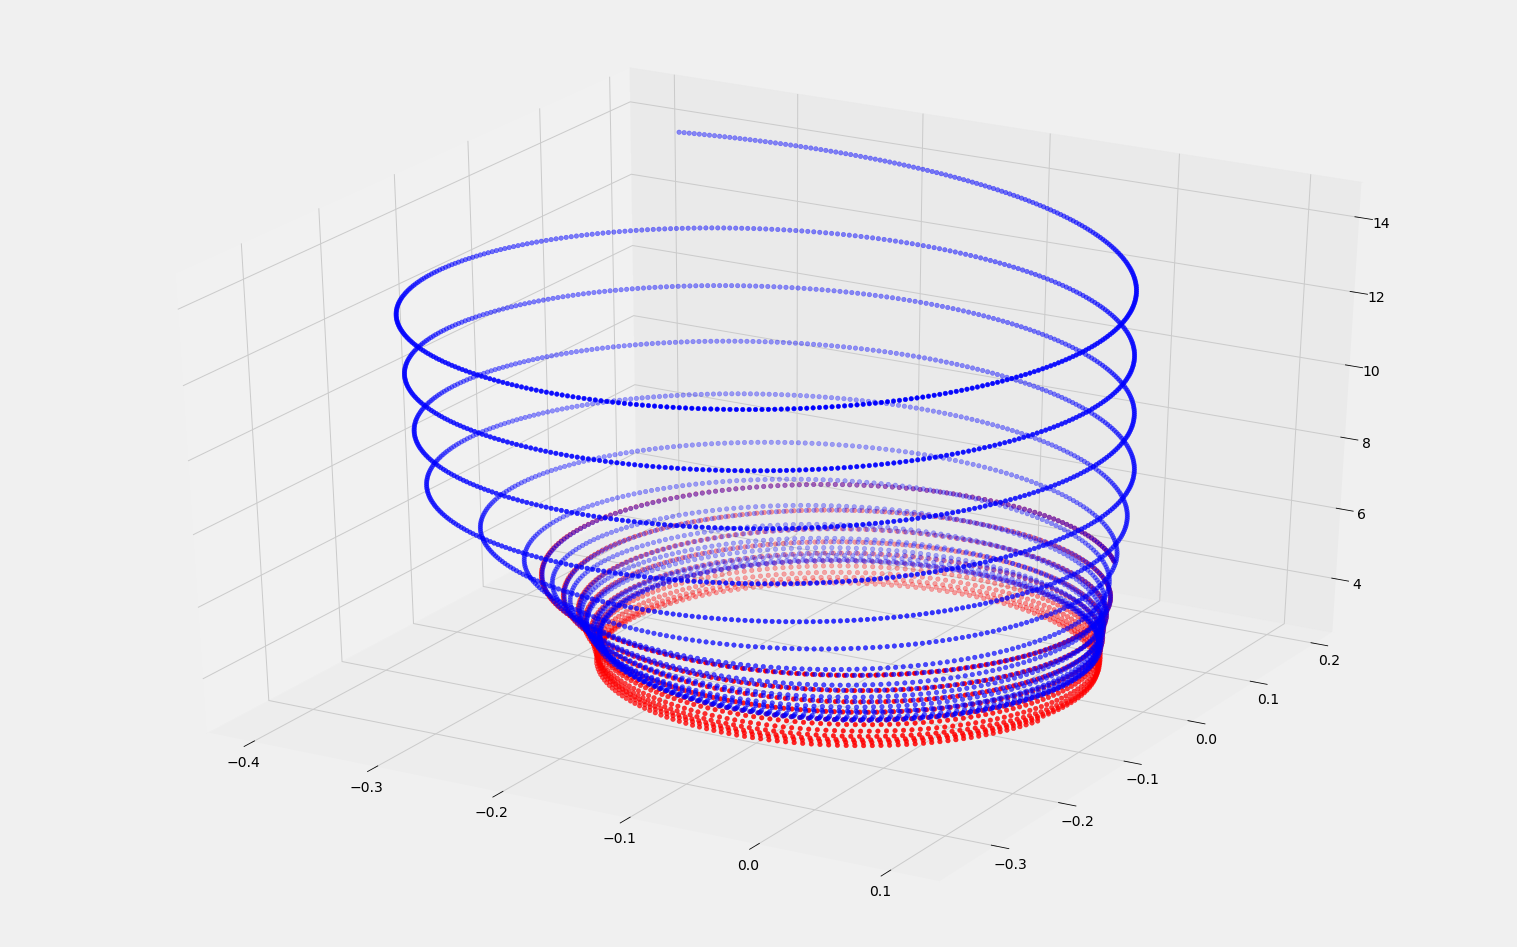

In [45]:
filedata[0]
filedata2[0]
def plots(filenom, filedis):
    e_solvernom = trajectory_solver.from_pickle(mao13datadir+filenom)
    e_solverdis = trajectory_solver.from_pickle(mao13datadir+filedis)

    xs = e_solvernom.dataframe.x.values
    ys = e_solvernom.dataframe.y.values
    zs = e_solvernom.dataframe.z.values

    xs2 = e_solverdis.dataframe.x.values
    ys2 = e_solverdis.dataframe.y.values
    zs2 = e_solverdis.dataframe.z.values

    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    ax.scatter(xs, ys, zs, c = 'b')
    ax.scatter(xs2, ys2, zs2, c = 'r')
    
plots(filedata2[3], filedata[3])

In [4]:
e_solvernom = trajectory_solver.from_pickle(mao13datadir+filenom)
e_solverdis = trajectory_solver.from_pickle(mao13datadir+filedis)
e_solvernom.plot_3D


NameError: name 'filenom' is not defined

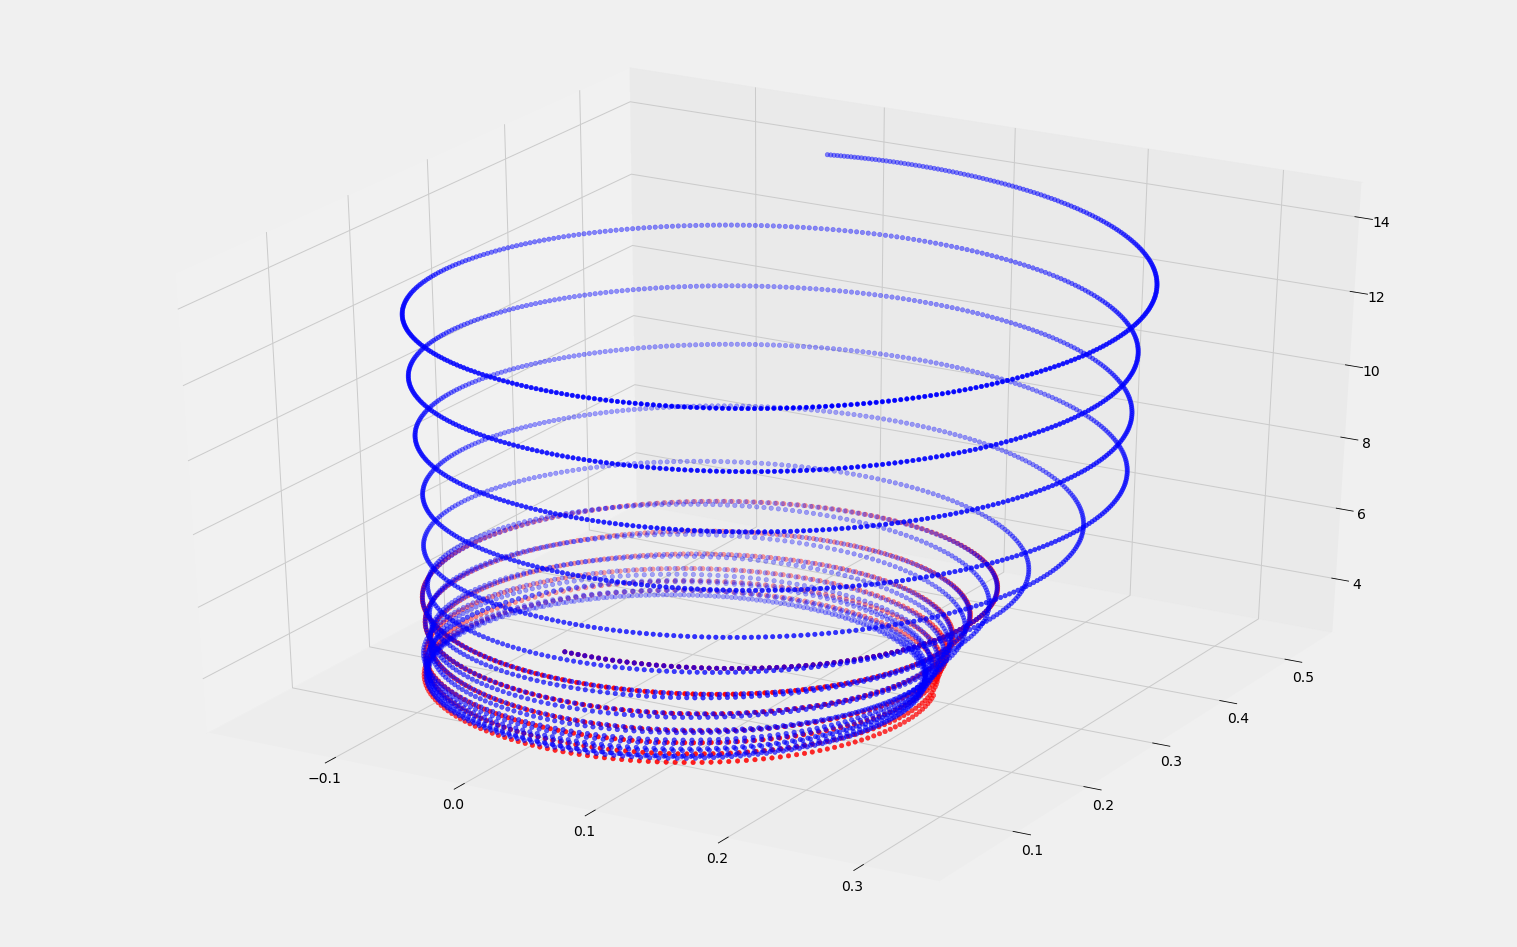

In [52]:
plots(filedata4[17], filedata3[17])